<img src="http://xarray.pydata.org/en/stable/_static/dataset-diagram-logo.png" align="center" width="30%">

# 04_Xarray_Variables: More CFSR plotting

## Overview
1. Select a date and access various CFSR Datasets
1. Subset the desired Datasets along their dimensions
1. Perform unit conversions
1. Create a well-labeled multi-parameter plot of gridded CFSR reanalysis data

## Imports

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from datetime import datetime as dt
from metpy.units import units
import metpy.calc as mpcalc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

## Select a date and time, and access several CFSR Datasets

In [2]:
# Date/Time specification
Year = 2013
Month = 5
Day = 20
Hour = 18
Minute = 0
dateTime = dt(Year,Month,Day, Hour, Minute)
timeStr = dateTime.strftime("%Y-%m-%d %H%M UTC")


### Create Xarray `Dataset` objects, each pointing to their respective NetCDF files in the `/cfsr/data` directory tree, using Xarray's [open_dataset](http://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html) method.

In [3]:
dsZ = xr.open_dataset (f'/cfsr/data/{Year}/g.{Year}.0p5.anl.nc')
dsT = xr.open_dataset (f'/cfsr/data/{Year}/t.{Year}.0p5.anl.nc')
dsU = xr.open_dataset (f'/cfsr/data/{Year}/u.{Year}.0p5.anl.nc')
dsV = xr.open_dataset (f'/cfsr/data/{Year}/v.{Year}.0p5.anl.nc')
dsQ = xr.open_dataset (f'/cfsr/data/{Year}/q.{Year}.0p5.anl.nc')
dsSLP = xr.open_dataset (f'/cfsr/data/{Year}/pmsl.{Year}.0p5.anl.nc')

### Let's examine one of the Datasets.

In [4]:
dsZ

<xarray.Dataset>
Dimensions:  (time: 1460, lat: 361, lon: 720, lev: 32)
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2013-12-31T18:00:00
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lev      (lev) float32 1e+03 975.0 950.0 925.0 900.0 ... 50.0 30.0 20.0 10.0
Data variables:
    g        (time, lev, lat, lon) float32 ...
Attributes:
    description:    g 1000-10 hPa
    year:           2013
    source:         http://nomads.ncdc.noaa.gov/data.php?name=access#CFSR-data
    references:     Saha, et. al., (2010)
    created_by:     User: abrammer
    creation_date:  Sat Nov  9 12:03:29 MST 2013

## Subset the desired `Dataset`s along their dimensions.

### We will use the `sel` method on the latitude and longitude dimensions as well as time and isobaric surface.

In [17]:
# Areal extent
lonW = -120
lonE = -80
latS = 20
latN = 55
cLat, cLon = (latS + latN)/2, (lonW + lonE)/2

expand = 0.5
latRange = np.arange(latS,latN + expand, .5) # expand the data range a bit beyond the plot range
lonRange = np.arange(lonW,lonE + expand, .5) # Need to match longitude values to those of the coordinate variable

# Vertical level specificaton
plevel = 850
levelStr = f'{plevel}' # Use for the figure title


# Data variable selection; modify depending on what variables you are interested in

T = dsT['t'].sel(time=dateTime,lev=plevel,lat=latRange,lon=lonRange)
U = dsU['u'].sel(time=dateTime,lev=plevel,lat=latRange,lon=lonRange)
V = dsV['v'].sel(time=dateTime,lev=plevel,lat=latRange,lon=lonRange)



### Output the level and time strings; we'll use them to create the figure's title.

In [18]:
levelStr, timeStr

('850', '2013-05-20 1800 UTC')

### Let's look at some of the attributes

In [19]:
T.units

'K'

In [20]:
U.units

'm s^-1'

In [21]:
V.units

'm s^-1'

#### Define our subsetted coordinate arrays of lat and lon. Pull them from any of the DataArrays. We'll need to pass these into the contouring functions later on.

In [22]:
lats = T.lat
lons = T.lon

## Perform unit conversions

#### We take the DataArrays and apply [MetPy's unit conversion method](https://unidata.github.io/MetPy/latest/tutorials/xarray_tutorial.html#units).

In [23]:
T = T.metpy.convert_units('degC')
U = U.metpy.convert_units('kts')
V = V.metpy.convert_units('kts')

## Create a well-labeled multi-parameter plot of gridded CFSR reanalysis data

In [24]:
proj_map = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
proj_data = ccrs.PlateCarree() # Our data is lat-lon; thus its native projection is Plate Carree.
res = '50m'

#### Now define the range of our contour values and a contour interval. 
This of course will depend on the level, time, region, and variable.

In [25]:
T.min(), T.max()

(<xarray.DataArray 't' ()>
 <Quantity(-0.04998779296875, 'degree_Celsius')>
 Coordinates:
     time     datetime64[ns] 2013-05-20T18:00:00
     lev      float32 850.0,
 <xarray.DataArray 't' ()>
 <Quantity(31.1500244140625, 'degree_Celsius')>
 Coordinates:
     time     datetime64[ns] 2013-05-20T18:00:00
     lev      float32 850.0)

In [26]:
minTVal = -30
maxTVal = 22
cint = 2
Tcintervals = np.arange(minTVal, maxTVal, cint)
Tcintervals

array([-30, -28, -26, -24, -22, -20, -18, -16, -14, -12, -10,  -8,  -6,
        -4,  -2,   0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20])

#### Plot the map

In this example: filled contours of 850 hPa temperature and wind barbs.

Create a meaningful title string.

In [27]:
tl1 = f'CFSR {levelStr} hPa temperature ($^\circ$C, filled contours) and winds (kts, barbs)'
tl2 = f'Valid at: {timeStr}'
title_line = (tl1 + '\n' + tl2 + '\n') # concatenate the two strings and add return characters

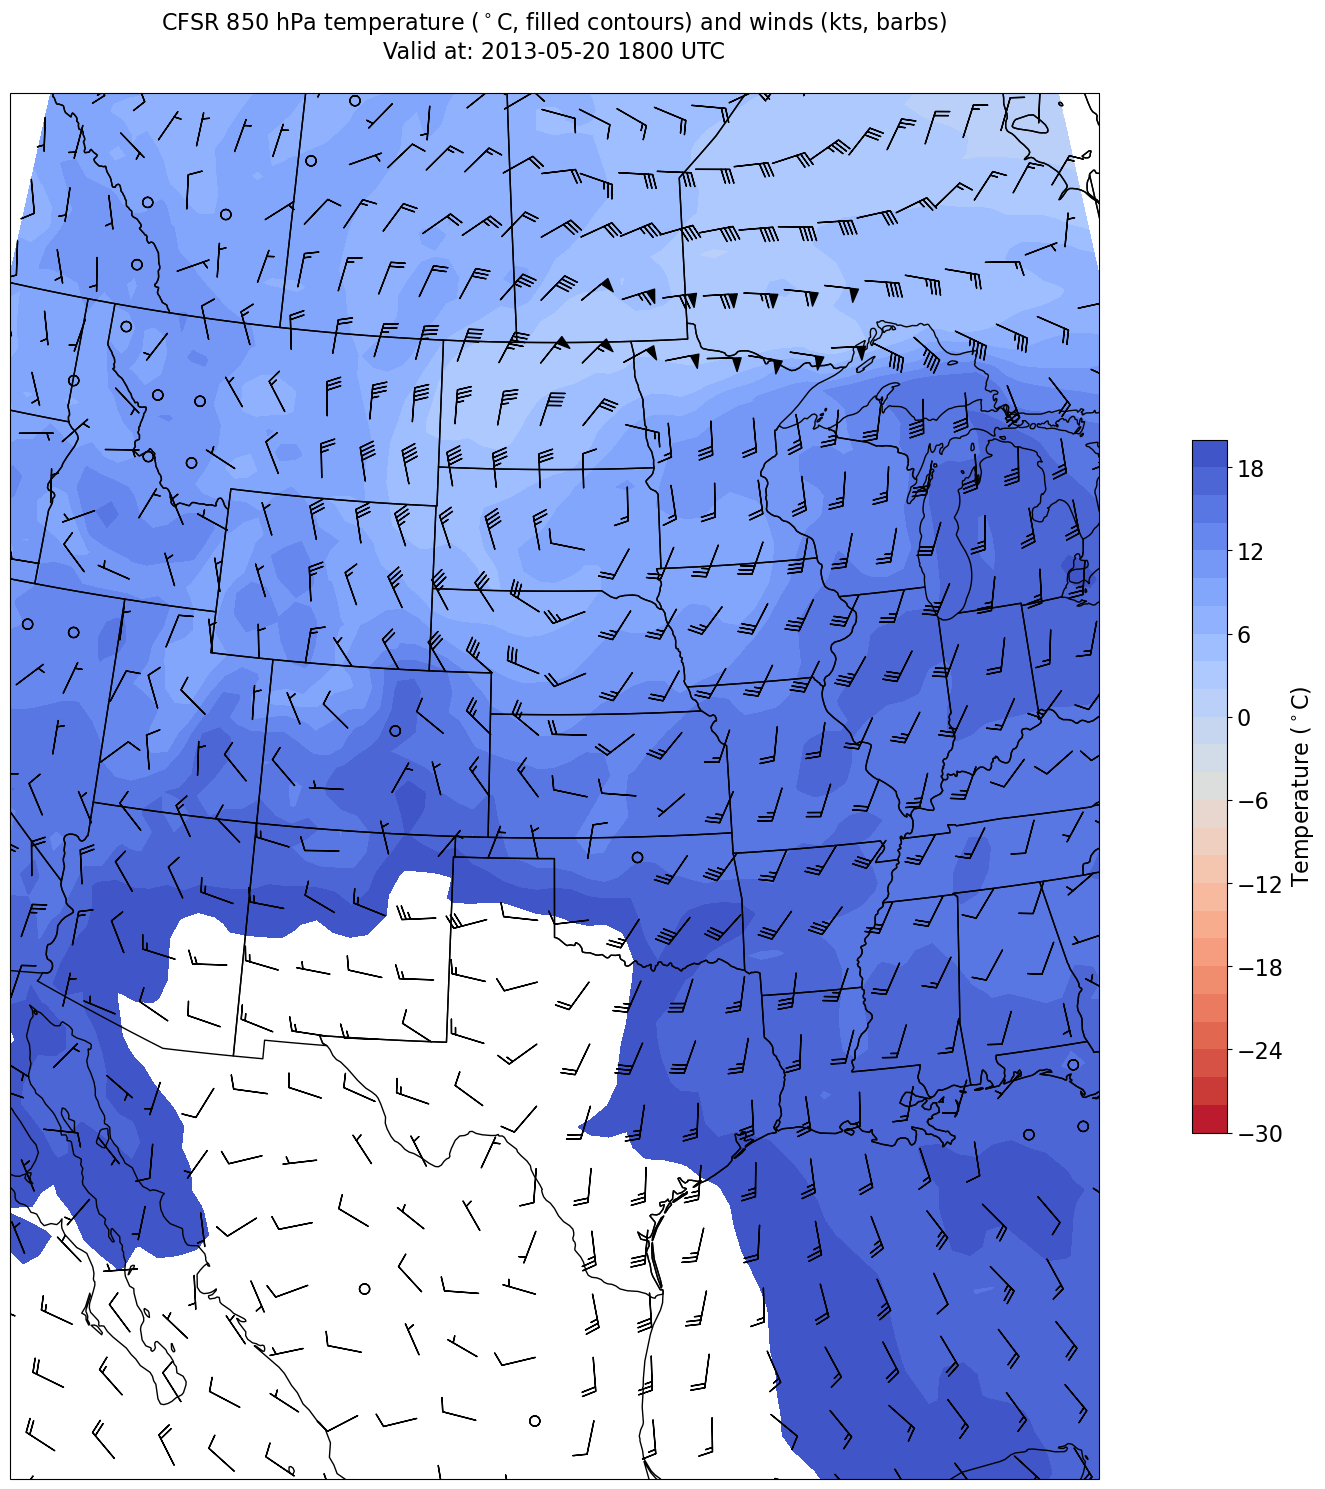

In [34]:
constrainLat, constrainLon = (0.7, 6.5)

fig = plt.figure(figsize=(24,18)) # Increase size to adjust for the constrained lats/lons
ax = plt.subplot(1,1,1,projection=proj_map)
ax.set_extent ([lonW+constrainLon,lonE-constrainLon,latS+constrainLat,latN-constrainLat])
ax.add_feature(cfeature.COASTLINE.with_scale(res))
ax.add_feature(cfeature.STATES.with_scale(res))
CF = ax.contourf(lons,lats,T, levels=Tcintervals,transform=proj_data,cmap='coolwarm_r')
cbar = plt.colorbar(CF,shrink=0.5)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_ylabel("Temperature ($^\circ$C)",fontsize=16)

# Plotting wind barbs uses the ax.barbs method. Here, you can't pass in the DataArray directly; you can only pass in the array's values.
# Also need to sample (skip) a selected # of points to keep the plot readable.
skip = 3
ax.barbs(lons[::skip],lats[::skip],U[::skip,::skip].values, V[::skip,::skip].values, transform=proj_data)

title = plt.title(title_line,fontsize=16)

## Now, go back and try different variables, times, regional subsets, and levels!